Case study: COMPAS and classifier fairness
------------------------------------------

![ProPublica headline](https://static.propublica.org/projects/algorithmic-bias/assets/img/generated/opener-b-crop-2400*1350-00796e.jpg)

About COMPAS
------------

COMPAS is a tool used in many jurisdictions around the U.S. to predict *recidivism* risk - the risk that a criminal defendant will reoffend.

-   COMPAS assigns scores from 1 (lowest risk) to 10 (highest risk).
-   It also assigns a class: each sample is labeled as high risk of recidivism, medium risk of recidivism, or low risk of recidivism. For this analysis, we turn it into a binary classification problem by re-labeling as medium or high risk of recidivism vs. low risk of recidivism.
-   As input, the model uses 137 factors, including age, gender, and criminal history of the defendant.
-   Race is *not* an explicit feature considered by the model.

### Using COMPAS

-   Judges can see the defendant’s COMPAS score when deciding whether to detain the defendant prior to trial and/or when sentencing.
-   Defendants who are classified medium or high risk (scores of 5-10), are more likely to be held in prison while awaiting trial than those classified as low risk (scores of 1-4).

### ProPublica claims (1)

> Prediction Fails Differently for Black Defendants

|                                           | WHITE | AFRICAN AMERICAN |
|-------------------------------------------|:------|:-----------------|
| Labeled Higher Risk, But Didn’t Re-Offend | 23.5% | 44.9%            |
| Labeled Lower Risk, Yet Did Re-Offend     | 47.7% | 28.0%            |

### ProPublica claims (2)

> Overall, Northpointe’s assessment tool correctly predicts recidivism 61 percent of the time. But blacks are almost twice as likely as whites to be labeled a higher risk but not actually re-offend. It makes the opposite mistake among whites: They are much more likely than blacks to be labeled lower risk but go on to commit other crimes.

Replicating ProPublica analysis
-------------------------------

------------------------------------------------------------------------

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

### Read in the data

In [2]:
url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
df = pd.read_csv(url)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7214 non-null   int64  
 1   name                     7214 non-null   object 
 2   first                    7214 non-null   object 
 3   last                     7214 non-null   object 
 4   compas_screening_date    7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   dob                      7214 non-null   object 
 7   age                      7214 non-null   int64  
 8   age_cat                  7214 non-null   object 
 9   race                     7214 non-null   object 
 10  juv_fel_count            7214 non-null   int64  
 11  decile_score             7214 non-null   int64  
 12  juv_misd_count           7214 non-null   int64  
 13  juv_other_count          7214 non-null   int64  
 14  priors_count            

In [4]:
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


### Transform into a binary classification problem

First, let’s make this a binary classification problem. We will add a new column that translates the risk score (`decile_score`) into a binary label.

Any score 5 or higher (Medium or High risk) means that a defendant is treated as a likely recividist, and a score of 4 or lower (Low risk) means that a defendant is treated as unlikely to reoffend.

In [5]:
df['is_med_or_high_risk']  = (df['decile_score']>=5).astype(int)

In [6]:
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,is_med_or_high_risk
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1,0
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1,0
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0,1
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,Low,2013-03-26,NaN,NaN,2,0,1102,0,0,0


We are using this data as a case study in evaluating the performance of a binary classifier.

-   Which column in this data frame represents $\hat{y}$, the prediction of a binary classifier?
-   Which column in this data frame represents $y$, the actual outcome that the classifier is trying to predict?

### Evaluate model performance

To evaluate the performance of the model, we will compare the model’s predictions to the “truth”:

-   The risk score prediction of the COMPAS system is in the `decile_score` column,
-   The classification of COMPAS as medium/high risk or low risk is in the `is_med_or_high_risk` column
-   The “true” recidivism value (whether or not the defendant committed another crime in the next two years) is in the `two_year_recid` column.

Let’s start by computing the accuracy:

In [7]:
np.mean(df['is_med_or_high_risk']==df['two_year_recid'])

np.float64(0.6537288605489326)

In comparison to “prediction by mode”:

In [8]:
np.mean(df['two_year_recid'])

np.float64(0.45065151095092876)

This, itself, might already be considered problematic...

-   it’s not at all obvious that pretrial release and sentencing decisions benefit from a risk assessment that is just a bit better than a random classifier, and
-   it’s not obvious that the people using these risk assessment scores (for example, judges) are aware that the accuracy is so low.

The accuracy score includes both kinds of errors:

-   false positives (defendant is predicted as medium/high risk but does not reoffend)
-   false negatives (defendant is predicted as low risk, but does reoffend)

but these errors have different costs.

(Which has a higher “cost”: giving an overly harsh sentence to someone who will not reoffend, or giving a too-lenient sentence to someone who will reoffend?)

It can be useful to pull out the different types of errors separately, to see the rate of different types of errors.

If we create a confusion matrix, we can use it to derive a whole set of classifier metrics:

-   True Positive Rate (TPR) also called recall or sensitivity
-   True Negative Rate (TNR) also called specificity
-   Positive Predictive Value (PPV) also called precision
-   Negative Predictive Value (NPV)
-   False Positive Rate (FPR)
-   False Discovery Rate (FDR)
-   False Negative Rate (FNR)
-   False Omission Rate (FOR)

![](https://ffund.github.io/intro-ml-tss21/images/ConfusionMatrix.svg)

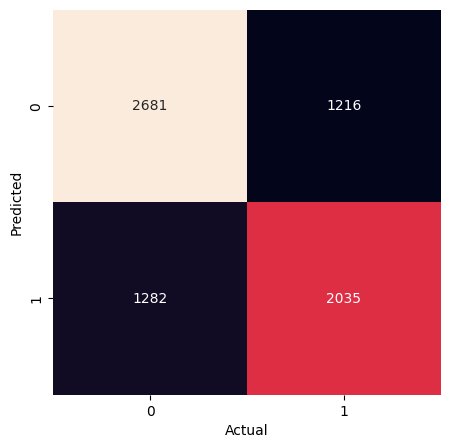

In [9]:
cm = pd.crosstab(df['is_med_or_high_risk'], df['two_year_recid'],
                               rownames=['Predicted'], colnames=['Actual'])
p = plt.figure(figsize=(5,5));
p = sns.heatmap(cm, annot=True, fmt="d", cbar=False)

We can also use `sklearn`'s `confusion_matrix` to pull out these values and compute any metrics of interest:

In [10]:
[[tn , fp],[fn , tp]]  = confusion_matrix(df['two_year_recid'], df['is_med_or_high_risk'])
print("True negatives:  ", tn)
print("False positives: ", fp)
print("False negatives: ", fn)
print("True positives:  ", tp)

True negatives:   2681
False positives:  1282
False negatives:  1216
True positives:   2035


Or we can compute them directly using `crosstab` -

Here, we normalize by row - show the PPV, FDR, FOR, NPV:

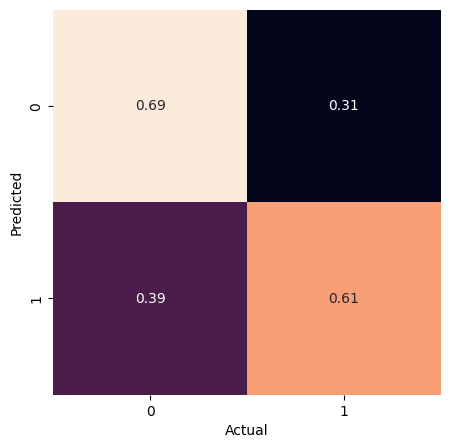

In [11]:
cm = pd.crosstab(df['is_med_or_high_risk'], df['two_year_recid'],
                               rownames=['Predicted'], colnames=['Actual'], normalize='index')
p = plt.figure(figsize=(5,5));
p = sns.heatmap(cm, annot=True, fmt=".2f", cbar=False)

Here, we normalize by colum - show the TPR, FPR, FNR, TNR:

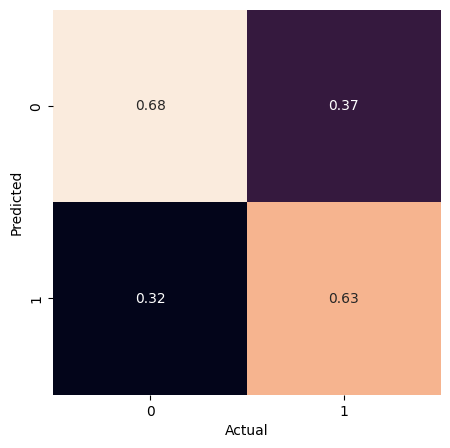

In [12]:
cm = pd.crosstab(df['is_med_or_high_risk'], df['two_year_recid'],
                               rownames=['Predicted'], colnames=['Actual'], normalize='columns')
p = plt.figure(figsize=(5,5));
p = sns.heatmap(cm, annot=True, fmt=".2f", cbar=False)

Overall, we see that a defendant has a similar likelihood of being wrongly labeled a likely recidivist and of being wrongly labeled as unlikely to reoffend:

In [13]:
fpr = fp/(fp+tn)
tpr = tp/(tp+fn)
fnr = fn/(fn+tp)
tnr = tn/(tn+fp)

print("False positive rate (overall): ", fpr)
print("False negative rate (overall): ", fnr)

False positive rate (overall):  0.32349230381024474
False negative rate (overall):  0.3740387573054445


We can also directly evaluate the risk score, instead of just the labels. The risk score is meant to indicate the probability that a defendant will reoffend.

In [14]:
d = df.groupby('decile_score').agg({'two_year_recid': 'mean'})

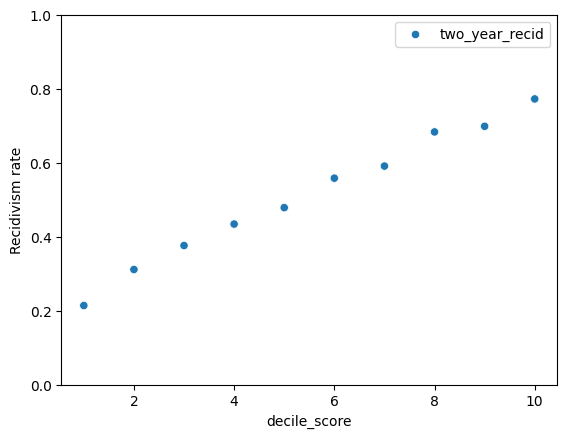

In [15]:
sns.scatterplot(data=d);
plt.ylim(0,1);
plt.ylabel('Recidivism rate');

Defendants with a higher COMPAS score indeed had higher rates of recidivism.

Finally, we can look at the ROC curve and AUC, which tells us how to work with the FPR-TPR tradeoff by setting the threshold for “medium or high risk” at different decile score levels.

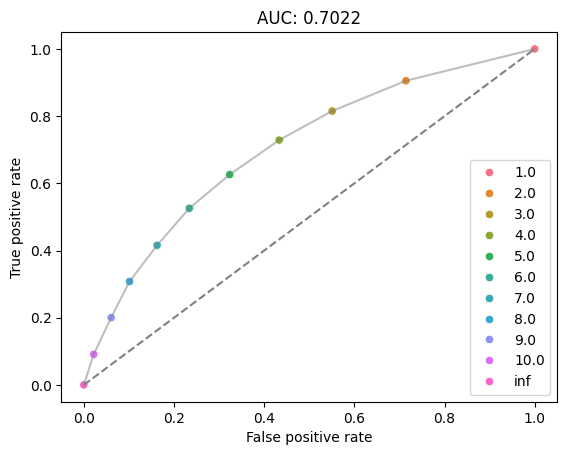

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(df['two_year_recid'], df['decile_score'])
auc = roc_auc_score(df['two_year_recid'], df['decile_score'])
sns.lineplot(x=fpr, y=tpr, color='gray', alpha=0.5);
sns.scatterplot(x=fpr, y=tpr, hue=pd.Categorical(thresholds), legend='full');
plt.plot([0, 1], [0, 1], color='gray', linestyle='--');
plt.title('AUC: %s' % ('{0:.4f}'.format(auc)));
plt.xlabel("False positive rate");
plt.ylabel("True positive rate");

### Fairness

A useful reference for the fairness definitions in this notebook: [Fairness Definitions Explained](https://fairware.cs.umass.edu/papers/Verma.pdf)

COMPAS has been under scrutiny for issues related for fairness with respect to race of the defendant.

Race is not an explicit input to COMPAS, but some of the questions that *are* used as input may have strong correlations with race.

First, we will find out how frequently each race is represented in the data:

In [17]:
df['race'].value_counts()

race
African-American    3696
Caucasian           2454
Hispanic             637
Other                377
Asian                 32
Native American       18
Name: count, dtype: int64

We will focus specifically on African-American or Caucasian defendants, since they are the subject of the ProPublica claim.

In [18]:
df = df[df.race.isin(["African-American","Caucasian"])]

First, let’s compare the accuracy for the two groups:

In [19]:
(df['two_year_recid']==df['is_med_or_high_risk']).astype(int).groupby(df['race']).mean()

race
African-American    0.638258
Caucasian           0.669927
dtype: float64

It isn’t exactly the same, but it’s similar - within a few points. This is a type of fairness known as **overall accuracy equality**.

Next, let’s see whether a defendant who is classified as medium/high risk has the same probability of recidivism for the two groups.

In other words, we will compute the PPV for each group:

$$PPV = \frac{TP}{TP+FP} = P(y=1 | \hat{y} = 1)$$

In [20]:
df[df['is_med_or_high_risk']==1]['two_year_recid'].groupby(df['race']).mean()

race
African-American    0.629715
Caucasian           0.591335
Name: two_year_recid, dtype: float64

Again, similar (within a few points). This is a type of fairness known as **predictive parity**.

We can extend this idea, to check whether a defendant with a given score has the same probability of recidivism for the two groups:

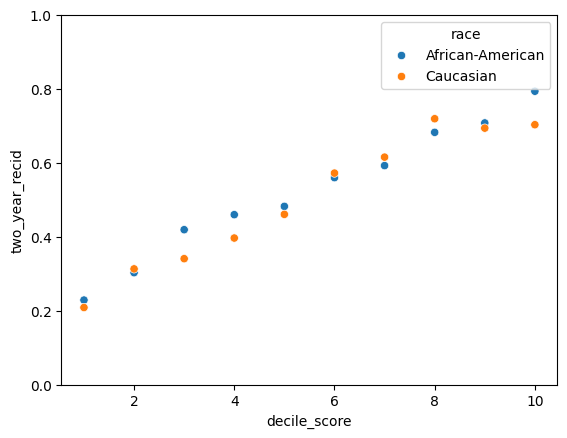

In [21]:
d = pd.DataFrame(df.groupby(['decile_score','race']).agg({'two_year_recid': 'mean'}))
d = d.reset_index()
im = sns.scatterplot(data=d, x='decile_score', y='two_year_recid', hue='race');
im.set(ylim=(0,1));

We can see that for both African-American and Caucasian defendants, for any given COMPAS score, recidivism rates are similar. This is a type of fairness known as **calibration**.

Next, we will look at the frequency with which defendants of each race are assigned each COMPAS score:

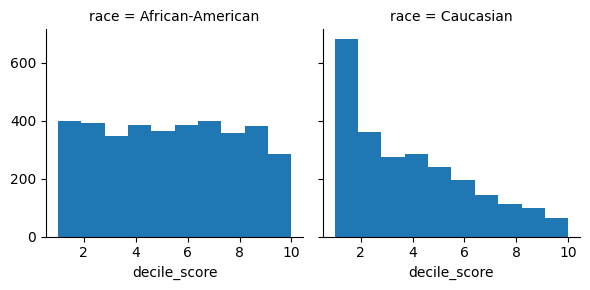

In [22]:
g = sns.FacetGrid(df, col="race", margin_titles=True);
g.map(plt.hist, "decile_score", bins=10);

We observe that Caucasian defendants in this sample are more likely to be assigned a low risk score.

However, to evaluate whether this is *unfair*, we need to know the true prevalence - whether the rates of recividism are the same in both populations, according to the data:

In [23]:
df.groupby('race').agg({'two_year_recid': 'mean',
                        'is_med_or_high_risk': 'mean',
                        'decile_score': 'mean'})

,two_year_recid,is_med_or_high_risk,decile_score
race,,,
African-American,0.514340,0.588203,5.368777
Caucasian,0.393643,0.348003,3.735126


The predictions of the model are fairly close to the actual prevalence in the population.

So far, our analysis suggests that COMPAS is fair with respect to race:

-   The overall accuracy of the COMPAS label is the same, regardless of race (**overall accuracy equality**)
-   The likelihood of recividism among defendants labeled as medium or high risk is similar, regardless of race (**predictive parity**)
-   For any given COMPAS score, the risk of recidivism is similar, regardless of race - the “meaning” of the score is consistent across race (**calibration**)

We do not have **statistical parity** (a type of fairness corresponding to equal probability of positive classification), but we don’t necessarily expect to when the prevalance of actual positive is different between groups.

### Revisiting the ProPublica claim

ProPublica made a specific claim:

> 23.5% of Caucasian defendants, 44.9% of African-American defendants were “Labeled Higher Risk, But Didn’t Re-Offend”

What metric should we check to evaluate whether this claim is correct?

$$FDR   = \frac{FP}{FP + TP} = P(y = 0 | \hat{y} = 1)$$

$$FPR = \frac{FP}{FP + TN} = P(\hat{y} = 1 | y=0)$$

$$FOR   = \frac{FN}{FN + TN} = P(y = 1 |\hat{y} = 0)$$

$$FNR = \frac{FN}{TP + FN} = P(\hat{y} = 0 | y=1)$$

Is “Labeled Higher Risk, But Didn’t Re-Offend” the same thing as "Didn’t Re-Offend, But Labeled Higher Risk?

In the following image, the top row shows the confusion matrix normalized by row - the PPV, FDR, FOR, NPV - by race. The bottom row shows the confusion matrix normalized by column - TPR, FPR, FNR, TNR.

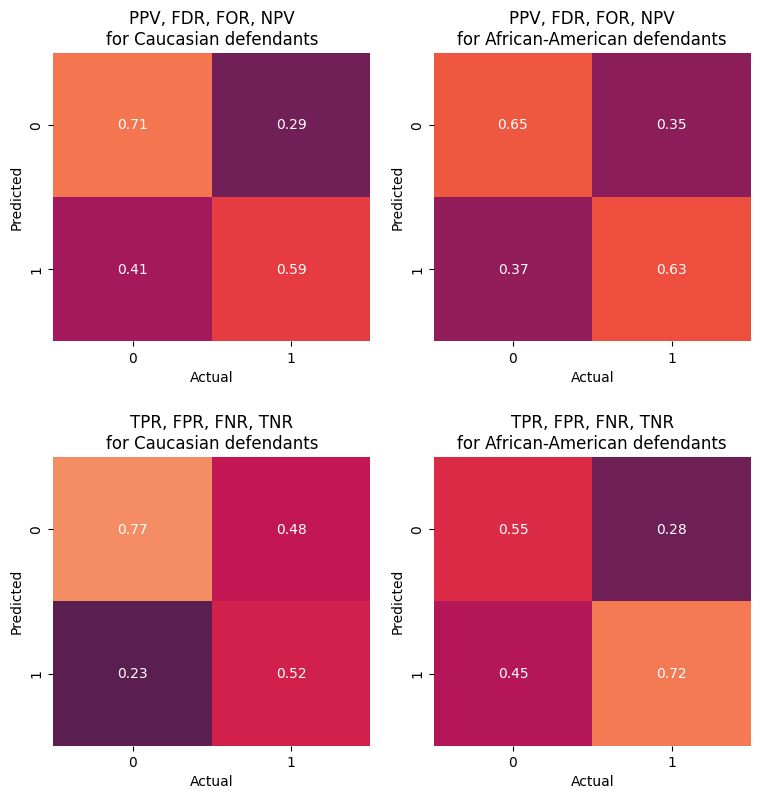

In [24]:
p = plt.figure(figsize=(9,9));
plt.subplots_adjust(hspace=0.4)

for i, race in enumerate(['Caucasian', 'African-American']):
  cm = pd.crosstab(df[df.race.eq(race)]['is_med_or_high_risk'], df[df.race.eq(race)]['two_year_recid'],
                               rownames=['Predicted'], colnames=['Actual'], normalize='index')
  p = plt.subplot(2,2,i+1)
  p = sns.heatmap(cm, annot=True, fmt=".2f", cbar=False, vmin=0, vmax=1)
  p = plt.title("PPV, FDR, FOR, NPV\nfor %s defendants" % race)

for i, race in enumerate(['Caucasian', 'African-American']):
  cm = pd.crosstab(df[df.race.eq(race)]['is_med_or_high_risk'], df[df.race.eq(race)]['two_year_recid'],
                               rownames=['Predicted'], colnames=['Actual'], normalize='columns')
  p = plt.subplot(2,2,i+3)
  p = sns.heatmap(cm, annot=True, fmt=".2f", cbar=False, vmin=0, vmax=1)
  p = plt.title("TPR, FPR, FNR, TNR\nfor %s defendants" % race)

### Can we fix it?

What if we adjust the thresholds separately for each group, to try and equalize the error rates?

In [25]:
thresholds = {'Caucasian': 4, 'African-American': 6}
df['threshold'] = df['race'].map(thresholds)
df['is_med_or_high_risk']  = (df['decile_score']>=df['threshold']).astype(int)

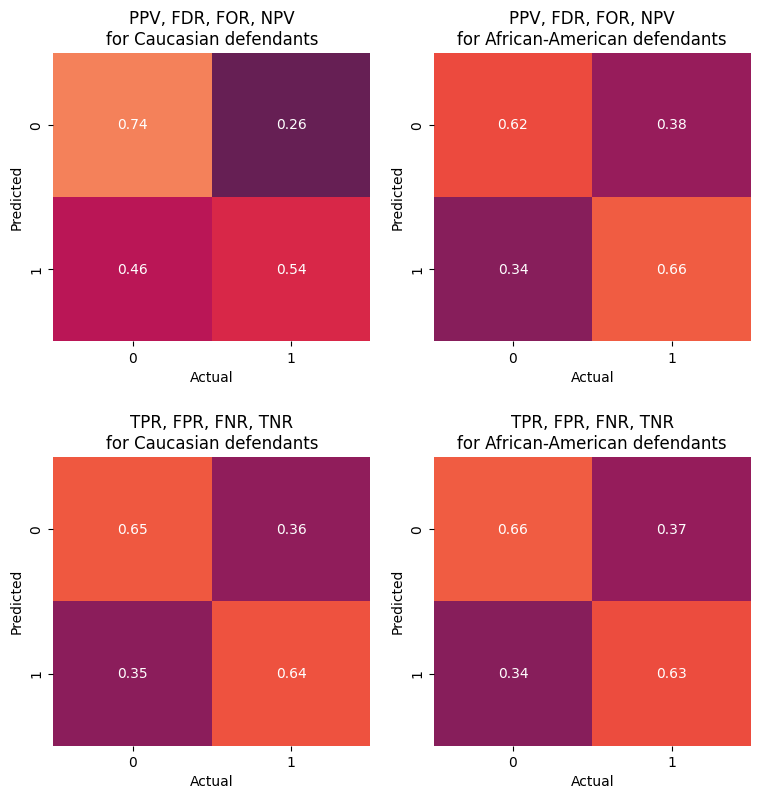

In [26]:
p = plt.figure(figsize=(9,9));
plt.subplots_adjust(hspace=0.4)

for i, race in enumerate(['Caucasian', 'African-American']):
  cm = pd.crosstab(df[df.race.eq(race)]['is_med_or_high_risk'], df[df.race.eq(race)]['two_year_recid'],
                               rownames=['Predicted'], colnames=['Actual'], normalize='index')
  p = plt.subplot(2,2,i+1)
  p = sns.heatmap(cm, annot=True, fmt=".2f", cbar=False, vmin=0, vmax=1)
  p = plt.title("PPV, FDR, FOR, NPV\nfor %s defendants" % race)

for i, race in enumerate(['Caucasian', 'African-American']):
  cm = pd.crosstab(df[df.race.eq(race)]['is_med_or_high_risk'], df[df.race.eq(race)]['two_year_recid'],
                               rownames=['Predicted'], colnames=['Actual'], normalize='columns')
  p = plt.subplot(2,2,i+3)
  p = sns.heatmap(cm, annot=True, fmt=".2f", cbar=False, vmin=0, vmax=1)
  p = plt.title("TPR, FPR, FNR, TNR\nfor %s defendants" % race)

Why is it so tricky to satisfy multiple types of fairness at once? This is due to a proven *impossibility result*.

Any time

-   the *base rate* (prevalence of the positive condition) is different in the two groups, and
-   we do not have a perfect classifier

Then we cannot simultaneously satisfy:

-   Equal PPV and NPV for both groups (known as **conditional use accuracy equality**), and
-   Equal FPR and FNR for both groups (known as **equalized odds** or **conditional procedure accuracy equality**)

The proof is in: [Inherent Trade-Offs in the Fair Determination of Risk Scores](https://arxiv.org/pdf/1609.05807.pdf)

Some interactive online demos on this:

-   Google's People + AI + Research (PAIR) group explainer: [Measuring fairness](https://pair.withgoogle.com/explorables/measuring-fairness/)
-   Another Google Explainer: [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/)

Are human decision-makers more fair?
------------------------------------

From [The accuracy, fairness, and limits of predicting recidivism](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5777393/) (Julia Dressel and Hany Farid, January 2018):

![Human vs. COMPAS predictions](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5777393/bin/aao5580-F1.jpg)

> Participants saw a short description of a defendant that included the defendant’s sex, age, and previous criminal history, but not their race (see Materials and Methods). Participants predicted whether this person would recidivate within 2 years of their most recent crime.… We compare these results with the performance of COMPAS.

Overview
--------

### What we learned

-   A model can be biased with respect to age, race, gender, even if those features are not used as input to the model. (“Fairness through unawareness” is often not very helpful!)
-   Human biases and unfairness in society leak into the data used to train machine learning models. For example, if Black defendants are subject to closer monitoring than white defendants, they might have higher rights of *measured* recidivism even if the underlying rates of offense were the same.
-   There are many measures of fairness, it may be impossible to satisfy some combination of these simultaneously.

### What we can do

What can we do to improve fairness of our machine learning models?

-   Are there policy/legal actions that might help?
    -   Justice in Forensic Algorithms Act [proposed by Rep. Mark Takano](https://medium.com/@repmarktakano/opening-the-black-box-of-forensic-algorithms-6194493b9960) would give defendants access to source code - would that help defendants facing unfair machine learning models?
-   What can we do, as machine learning engineers, that might help?
    -   Exploratory data analysis - look for possible underlying bias in the data.
    -   Avoid using sensitive group as a feature (or a proxy for a sensitive group), but this doesn’t necessarily help. (It didn’t help in this example.) Sometimes, using the sensitive group to explicitly *add* fairness might be better.
    -   Make sure different groups are well represented in the data.
    -   End users must be made aware of what the model output means - for example, judges should understand that a “high risk” label only means a 65% chance of reoffending.
    -   Evaluate final model for bias with respect to sensitive groups.
    -   May not be possible to satisfy multiple fairness metrics simultaneously, work with end users to decide which fairness metrics to prioritize, and to create a model that is fair w.r.t. that metric.

More details on the COMPAS analysis
-----------------------------------

-   Julia Angwin, Jeff Larson, Surya Mattu and Lauren Kirchner, May 2016, [Machine Bias](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing)
-   Jeff Larson, Surya Mattu, Lauren Kirchner and Julia Angwin, May 2016, [How We Analyzed the COMPAS Recidivism Algorithm](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm)
-   William Dieterich, Christina Mendoza, and Tim Brennan, July 2016, [COMPAS Risk Scales: Demonstrating Accuracy Equity and Predictive Parity](http://go.volarisgroup.com/rs/430-MBX-989/images/ProPublica_Commentary_Final_070616.pdf)